In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Environments

In [55]:
T = 250
K = 1
inventory = 10000

In [56]:
import numpy as np
import matplotlib.pyplot as plt

class Environment:
    def __init__(self, inventory=None):
        """
        inventory: int or None
          Max number of units that can be sold across all rounds.
          If None, no inventory constraint.
        """
        self.initial_inventory = int(inventory) if inventory is not None else None
        self.inventory = int(inventory) if inventory is not None else None
        self.sold_total = 0

    def _scalar_valuation(self, t):
        """
        Safely extract a scalar valuation for round t, even if valuations[t] is a vector.
        If it's a vector (e.g., shape (K,)), use the first element.
        """
        v = np.asarray(self.valuations[t])
        return float(v.ravel()[0])

    def round(self, p_t):
        # If inventory is constrained and depleted, no sale possible.
        if self.initial_inventory is not None and self.inventory <= 0:
            sold = 0
        else:
            v_t = self._scalar_valuation(self.t)
            sold = int(p_t <= v_t)

        # Apply inventory constraint (cannot sell if out of stock)
        if sold == 1 and self.initial_inventory is not None:
            if self.inventory > 0:
                self.inventory -= 1
                self.sold_total += 1
            else:
                sold = 0  # just in case of race, enforce constraint

        r_t = (p_t - self.cost) * sold
        self.rewards[self.t] = r_t
        self.t += 1
        return r_t / 100  # keep your original scaling

    def get_valuations(self):
        return self.valuations

    def get_inventory_remaining(self):
        return self.inventory if self.initial_inventory is not None else None

    def is_stocked_out(self):
        return (self.initial_inventory is not None) and (self.inventory <= 0)

    def plot_valuations(self, T, K):
        plt.figure(figsize=(10, 6))
        for k in range(K):
            plt.plot(range(T), self.valuations[:, k], marker='o', label=f'Item {k+1}')
        plt.xlabel('Round')
        plt.ylabel('Valuation')
        plt.title('Valuations Over Time')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend()
        plt.show()


In [57]:
class StochasticEnvironment(Environment):
    def __init__(self, cost, var, T, K, inventory=None):
        super().__init__(inventory=inventory)
        # Valuations in [0,100); keep your original wraparound trick
        self.valuations = np.random.normal(loc=50, scale=var, size=(T, K)) % 100
        self.cost = cost
        self.rewards = np.zeros(T)
        self.t = 0

In [58]:
class AdversarialEnvironment(Environment):
    def __init__(self, cost, step, T, K, inventory=None):
        super().__init__(inventory=inventory)
        self.valuations = np.zeros((T, K), dtype=int)
        self.cost = cost
        self.rewards = np.zeros(T)
        self.t = 0

        for t in range(int(T / step)):
            # after "step" rounds, we change mean and variance
            mean = (np.random.rand() * 100) % 100
            var = np.random.rand() * 20

            for i in range(step):
                vals = np.random.normal(loc=mean, scale=var, size=K)
                vals = np.round(vals) % 100   # wrap-around to keep in range
                idx = t * step + i
                if idx < T:
                    self.valuations[idx] = vals.astype(int)

In [59]:
class AntiUCB1Environment(Environment):
    def __init__(self, agent, T, cost=5, inventory=None):
        """
        agent: bandit agent with fields average_rewards, range, N_pulls
        T: time horizon
        cost: unit cost
        inventory: max total units that can be sold across the whole horizon (None = unlimited)
        """
        super().__init__(inventory=inventory)
        self.T = T
        self.K = int(1 / (T ** (-1/3)))         # keep original semantics
        self.q = (T ** (-1/3)) * 100            # price quant
        self.valuations = np.zeros(T)
        self.cost = cost
        self.rewards = np.zeros(T)
        self.t = 0
        self.agent = agent

    def _adversarial_valuation(self):
        # Standard UCB1-style upper bounds
        ucbs = self.agent.average_rewards + self.agent.range * np.sqrt(
            2 * np.log(self.T) / self.agent.N_pulls
        )
        return (np.argmax(ucbs) * self.q - 1) % 100

    def round(self, p_t):
        """
        Executes a real round: advances time, writes rewards, and (if inventory is set)
        decrements inventory on a sale. If out of stock, no sale can occur.
        """
        # If stocked out, no sale/revenue but time still advances
        if self.initial_inventory is not None and self.inventory <= 0:
            self.valuations[self.t] = 0.0
            r_t = 0.0
            self.rewards[self.t] = r_t
            self.t += 1
            return r_t / 100

        v_t = self._adversarial_valuation()
        self.valuations[self.t] = v_t

        sold = int(p_t <= v_t)

        # Enforce inventory constraint
        if sold == 1 and self.initial_inventory is not None:
            if self.inventory > 0:
                self.inventory -= 1
                self.sold_total += 1
            else:
                sold = 0  # just in case

        r_t = (p_t - self.cost) * sold
        self.rewards[self.t] = r_t
        self.t += 1
        return r_t / 100

    def fake_round(self, p_t):
        """
        Hypothetical evaluation: does NOT advance time or change inventory/rewards.
        If out of stock, returns 0 (no sale possible).
        """
        if self.initial_inventory is not None and self.inventory <= 0:
            return 0.0

        ucbs = self.agent.average_rewards + self.agent.range * np.sqrt(
            2 * np.log(self.T) / self.agent.N_pulls
        )
        v_t = (np.argmax(ucbs) * self.q - 1) % 100

        # Keep original behavior: store the current t's valuation but don't advance t
        self.valuations[self.t] = v_t

        sold = int(p_t <= v_t)
        r_t = (p_t - self.cost) * sold
        return r_t / 100

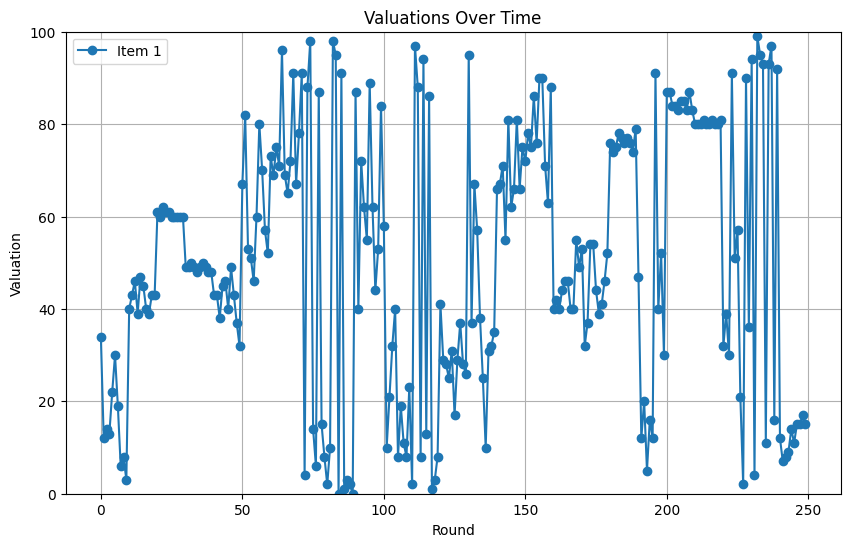

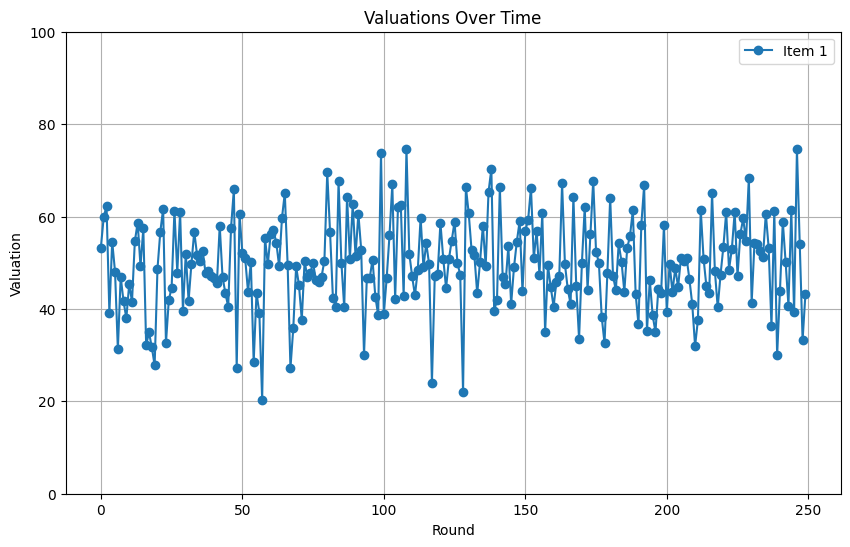

In [60]:
adv = AdversarialEnvironment(cost = 5, step = 10, T = T, K = K, inventory=inventory)
adv.plot_valuations(T, K)

stc = StochasticEnvironment(cost = 5, var = 10, T = T, K = K, inventory=inventory)
stc.plot_valuations(T, K)

# Agents

In [61]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, r_t):
        pass

    def compute_regret(self, env):
        """
        Regret vs. the best single fixed price chosen in hindsight,
        with the SAME inventory constraint as the environment.

        If env.initial_inventory is None -> unlimited inventory (old behavior).
        """
        vals = np.asarray(env.valuations).reshape(-1)  # robust to 1D/2D
        T = len(vals)
        K, q, cost = self.K, self.q, float(env.cost)
        inv_cap = getattr(env, "initial_inventory", None)  # None => unlimited

        # Total (hindsight) revenue for each arm, respecting inventory cap
        total_revs = np.zeros(K, dtype=float)

        for a in range(K):
            p = a * q
            margin = (p - cost) / 100.0
            if margin <= 0:
                total_revs[a] = 0.0
                continue
            # count rounds where sale would occur at price p
            cnt = int(np.sum(vals >= p))  # use >= to match "p <= v"
            if inv_cap is not None:
                cnt = min(cnt, int(inv_cap))
            total_revs[a] = margin * cnt

        o_a = int(np.argmax(total_revs))
        o_p = o_a * q
        margin = (o_p - cost) / 100.0

        # Build the oracle per-round revenue vector with inventory cap
        o_r = np.zeros(T, dtype=float)
        if margin > 0:
            if inv_cap is None:
                # Unlimited inventory: sell in every qualifying round
                mask = vals >= o_p
                o_r[mask] = margin
            else:
                remaining = int(inv_cap)
                for t in range(T):
                    if remaining > 0 and vals[t] >= o_p:
                        o_r[t] = margin
                        remaining -= 1

        regret = np.cumsum(o_r) - np.cumsum(self.rewards[:T])
        return regret

In [62]:
class UCB1Agent(Agent):
    def __init__(self, T, range=1):
        self.K = int(1 / (T ** (-1/3)))     # = floor(T^(1/3))
        self.q = (T ** (-1/3)) * 100        # quantization step
        self.T = T
        self.range = range
        self.a_t = None
        self.rewards = np.zeros(self.T)
        self.average_rewards = np.zeros(self.K, dtype=np.float64)
        self.N_pulls = np.zeros(self.K, dtype=int)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            # All arms have at least 1 pull after warm-up -> no div-by-zero
            ucbs = self.average_rewards + self.range * np.sqrt(
                2 * np.log(self.T) / self.N_pulls
            )
            self.a_t = int(np.argmax(ucbs))
        return self.a_t * self.q

    def update(self, r_t):
        self.rewards[self.t] = r_t
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] = (
            (self.average_rewards[self.a_t] * (self.N_pulls[self.a_t] - 1)) + r_t
        ) / self.N_pulls[self.a_t]
        self.t += 1

In [63]:
class EXP3Agent(Agent):
    def __init__(self, T):
        K = int(1 / (T ** (-1/3)))          # = floor(T^(1/3))
        self.K = K
        self.T = T
        self.q = (T ** (-1/3)) * 100
        # EXP3 with losses; reward in [0,1] thanks to /100 scaling in env
        self.learning_rate = np.sqrt(np.log(K) / (K * T))

        self.weights = np.ones(K)
        self.rewards = np.zeros(self.T)
        self.a_t = None
        self.x_t = np.ones(K) / K
        self.N_pulls = np.zeros(K, dtype=int)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / np.sum(self.weights)
        self.a_t = int(np.random.choice(np.arange(self.K), p=self.x_t))
        return self.a_t * self.q

    def update(self, r_t):
        self.rewards[self.t] = r_t
        # Importance-weighted loss estimate (loss = 1 - reward)
        l_t = 1.0 - r_t
        l_t_tilde = l_t / self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate * l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

# Tests

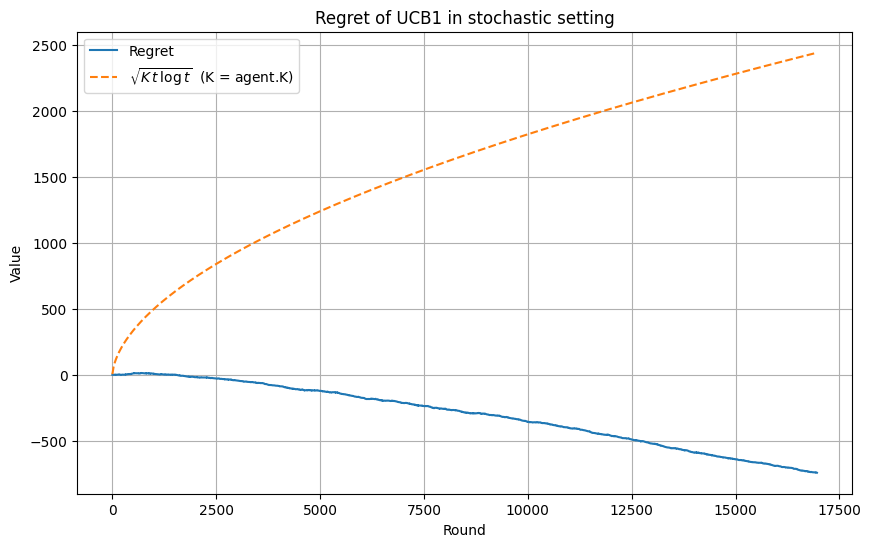

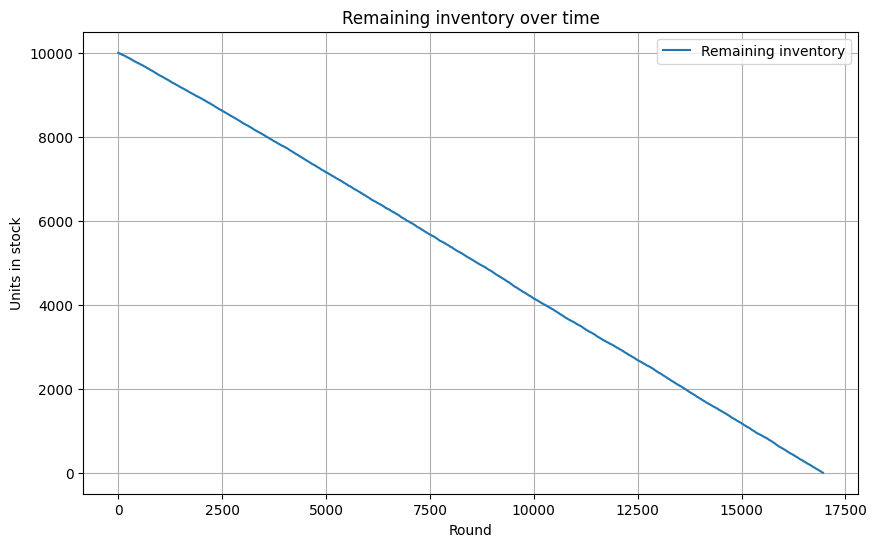

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables
T = 50_000
inventory = 10_000

agent = UCB1Agent(T=T)
env = StochasticEnvironment(cost=5, var=20, T=T, K=1, inventory=inventory)

# Simulate rounds
rewards = np.empty(T, dtype=float)
inv_remaining = np.empty(T, dtype=float)  # track remaining inventory after each round
rounds_played = 0

for t in range(T):
    # Optional early stop if env exposes stockout helper
    if hasattr(env, "is_stocked_out") and env.is_stocked_out():
        break

    p = agent.pull_arm()
    r = env.round(p)
    rewards[t] = r
    agent.update(r)

    # Record remaining inventory (handle both getter or raw attribute)
    if hasattr(env, "get_inventory_remaining"):
        inv_remaining[t] = env.get_inventory_remaining()
    elif hasattr(env, "inventory"):
        inv_remaining[t] = env.inventory
    else:
        inv_remaining[t] = np.nan

    rounds_played += 1

# Regret (vs best fixed price with same inventory cap)
regret = agent.compute_regret(env)[:rounds_played]

# Correct regret bound: use agent.K
t_values = np.arange(1, rounds_played + 1)
K_bound = agent.K
bound = np.sqrt(K_bound * t_values * np.log(np.maximum(2, t_values)))

# Plot regret vs bound
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, label='Regret')
plt.plot(t_values, bound, linestyle='--', label=r'$\sqrt{K\,t\,\log t}$  (K = agent.K)')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1 in stochastic setting')
plt.legend()
plt.grid(True)
plt.show()

# ---------- NEW: plot remaining inventory over time ----------
plt.figure(figsize=(10, 6))
plt.plot(t_values, inv_remaining[:rounds_played], label='Remaining inventory')
plt.xlabel('Round')
plt.ylabel('Units in stock')
plt.title('Remaining inventory over time')
plt.legend()
plt.grid(True)
plt.show()

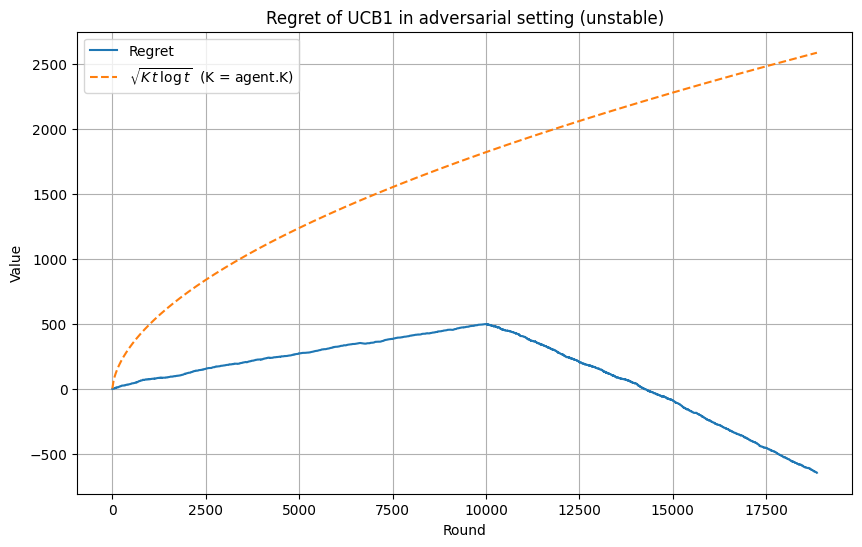

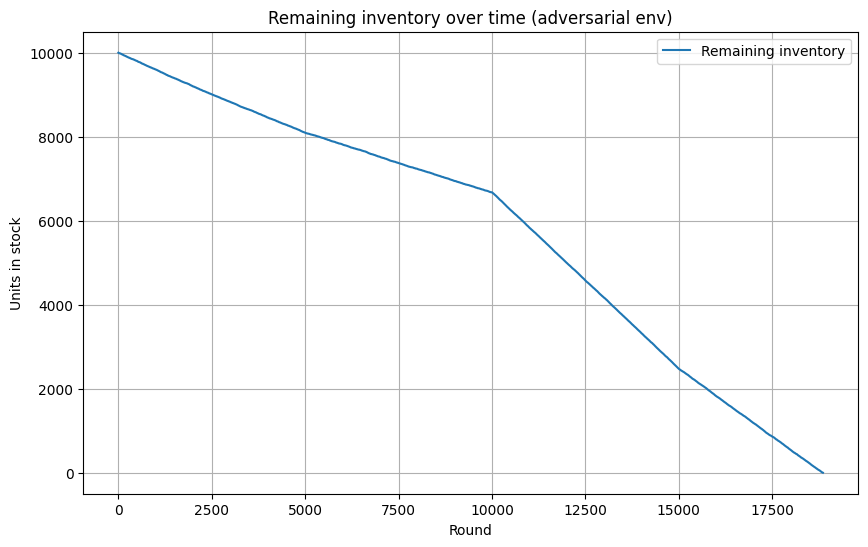

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
T = 50_000
inventory = 10_000  # Large -> inventory curve will look almost flat. Try 10_000 to see a slope.

agent = UCB1Agent(T=T)  # agent.K ~= T^(1/3)
env = AdversarialEnvironment(cost=5, step=T//10, T=T, K=1, inventory=inventory)

# --- Simulate ---
rewards = np.empty(T, dtype=float)
inv_remaining = np.empty(T, dtype=float)
rounds_played = 0

for t in range(T):
    # Optional early stop if env exposes a stockout helper
    if hasattr(env, "is_stocked_out") and env.is_stocked_out():
        break

    p = agent.pull_arm()
    r = env.round(p)
    rewards[t] = r
    agent.update(r)

    # Track remaining inventory robustly
    if hasattr(env, "get_inventory_remaining"):
        inv_remaining[t] = env.get_inventory_remaining()
    elif hasattr(env, "inventory"):
        inv_remaining[t] = env.inventory
    else:
        inv_remaining[t] = np.nan

    rounds_played += 1

# --- Regret & bound (truncate to rounds played) ---
regret = agent.compute_regret(env)[:rounds_played]
t_values = np.arange(1, rounds_played + 1)
K_bound = agent.K
bound = np.sqrt(K_bound * t_values * np.log(np.maximum(2, t_values)))  # ~ √(K t log t)

# --- Plots ---
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, label='Regret')
plt.plot(t_values, bound, linestyle='--', label=r'$\sqrt{K\,t\,\log t}$  (K = agent.K)')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1 in adversarial setting (unstable)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_values, inv_remaining[:rounds_played], label='Remaining inventory')
plt.xlabel('Round')
plt.ylabel('Units in stock')
plt.title('Remaining inventory over time (adversarial env)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-1188585049.py:22: RuntimeWarning: divide by zero encountered in divide
  2 * np.log(self.T) / self.agent.N_pulls


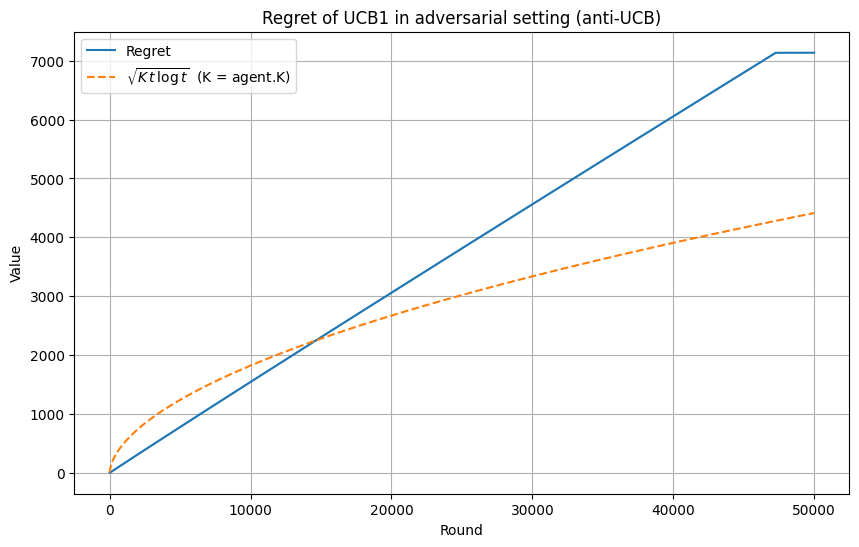

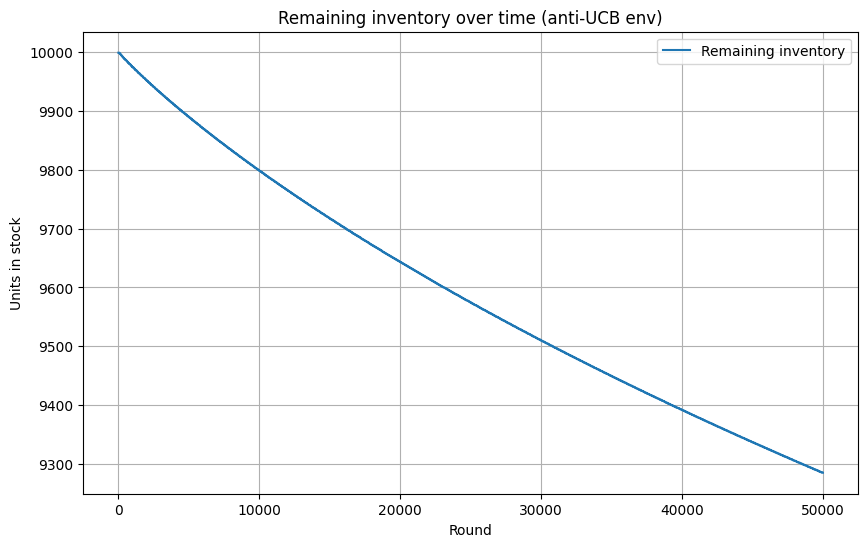

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
T = 50_000
inventory = 10_000 # try something smaller (e.g., 10_000) to see a clearer slope

agent = UCB1Agent(T)
env = AntiUCB1Environment(agent=agent, T=T, inventory=inventory)

# --- Simulate ---
rewards = np.empty(T, dtype=float)
inv_remaining = np.empty(T, dtype=float)
rounds_played = 0

for t in range(T):
    # Optional early stop if env exposes a stockout helper
    if hasattr(env, "is_stocked_out") and env.is_stocked_out():
        break

    p = agent.pull_arm()
    r = env.round(p)
    rewards[t] = r
    agent.update(r)

    # Track remaining inventory robustly
    if hasattr(env, "get_inventory_remaining"):
        inv_remaining[t] = env.get_inventory_remaining()
    elif hasattr(env, "inventory"):
        inv_remaining[t] = env.inventory
    else:
        inv_remaining[t] = np.nan

    rounds_played += 1

# --- Regret & bound (truncate to rounds played) ---
regret = agent.compute_regret(env)[:rounds_played]
t_values = np.arange(1, rounds_played + 1)
K_bound = agent.K
bound = np.sqrt(K_bound * t_values * np.log(np.maximum(2, t_values)))  # ~ √(K t log t)

# --- Plots ---
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, label='Regret')  # no markers for 50k points
plt.plot(t_values, bound, linestyle='--', label=r'$\sqrt{K\,t\,\log t}$  (K = agent.K)')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1 in adversarial setting (anti-UCB)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_values, inv_remaining[:rounds_played], label='Remaining inventory')
plt.xlabel('Round')
plt.ylabel('Units in stock')
plt.title('Remaining inventory over time (anti-UCB env)')
plt.legend()
plt.grid(True)
plt.show()


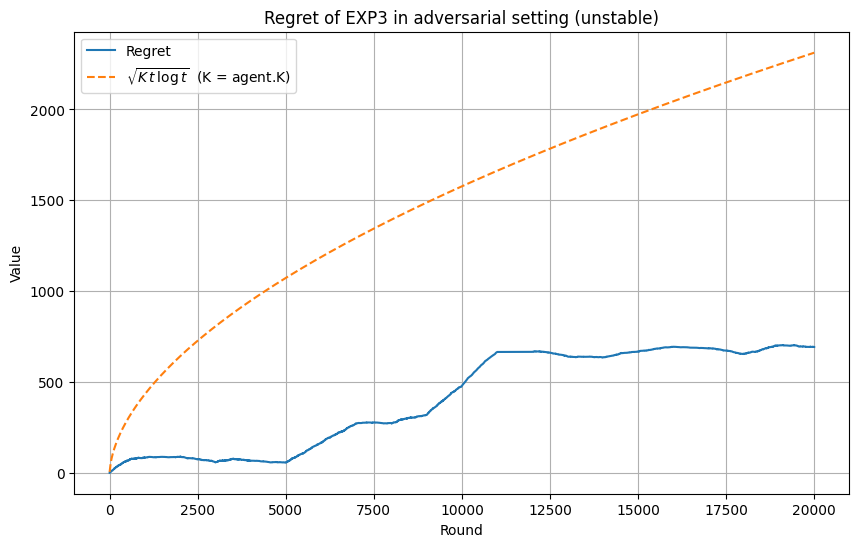

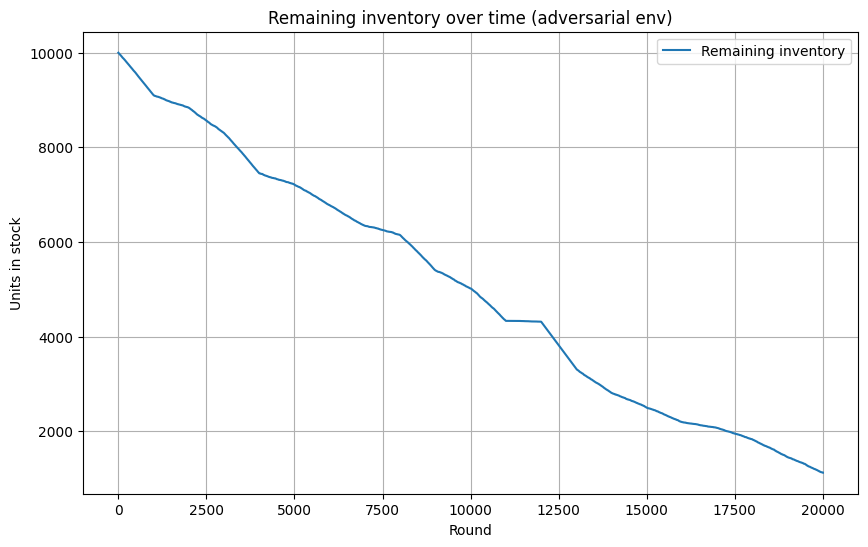

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
T = 20_000
inventory = 10_000  # try smaller (e.g., 10_000) to see a clearer slope

agent = EXP3Agent(T)
env = AdversarialEnvironment(cost=5, step=1000, T=T, K=1, inventory=inventory)

# --- Simulate ---
rewards = np.empty(T, dtype=float)
inv_remaining = np.empty(T, dtype=float)
rounds_played = 0

for t in range(T):
    # Optional early stop if the env exposes a stockout helper
    if hasattr(env, "is_stocked_out") and env.is_stocked_out():
        break

    p = agent.pull_arm()
    r = env.round(p)
    rewards[t] = r
    agent.update(r)

    # Track remaining inventory robustly
    if hasattr(env, "get_inventory_remaining"):
        inv_remaining[t] = env.get_inventory_remaining()
    elif hasattr(env, "inventory"):
        inv_remaining[t] = env.inventory
    else:
        inv_remaining[t] = np.nan

    rounds_played += 1

# --- Regret & bound (truncate to rounds played) ---
regret = agent.compute_regret(env)[:rounds_played]
t_values = np.arange(1, rounds_played + 1)
K_bound = agent.K
bound = np.sqrt(K_bound * t_values * np.log(np.maximum(2, t_values)))  # ~ √(K t log t)

# --- Plots ---
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, label='Regret')  # no markers for 50k points
plt.plot(t_values, bound, linestyle='--', label=r'$\sqrt{K\,t\,\log t}$  (K = agent.K)')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of EXP3 in adversarial setting (unstable)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_values, inv_remaining[:rounds_played], label='Remaining inventory')
plt.xlabel('Round')
plt.ylabel('Units in stock')
plt.title('Remaining inventory over time (adversarial env)')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-1188585049.py:66: RuntimeWarning: divide by zero encountered in divide
  2 * np.log(self.T) / self.agent.N_pulls
/tmp/ipython-input-1188585049.py:22: RuntimeWarning: divide by zero encountered in divide
  2 * np.log(self.T) / self.agent.N_pulls


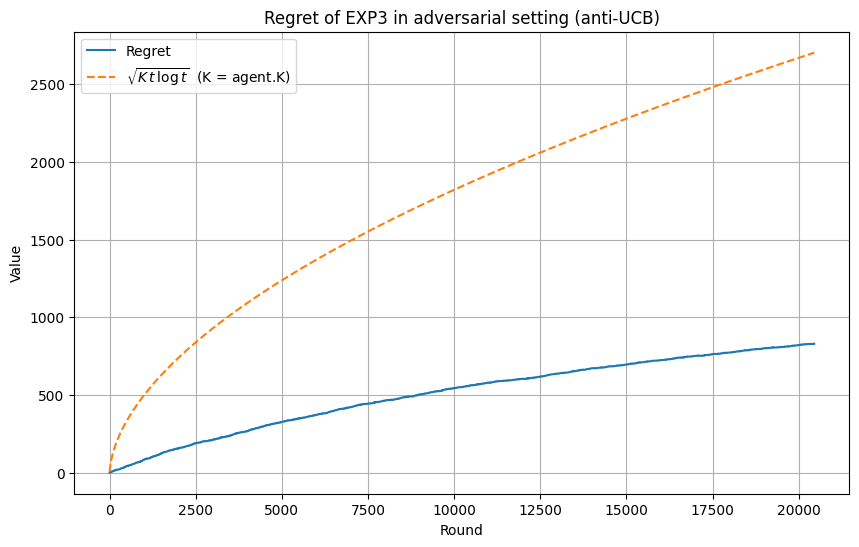

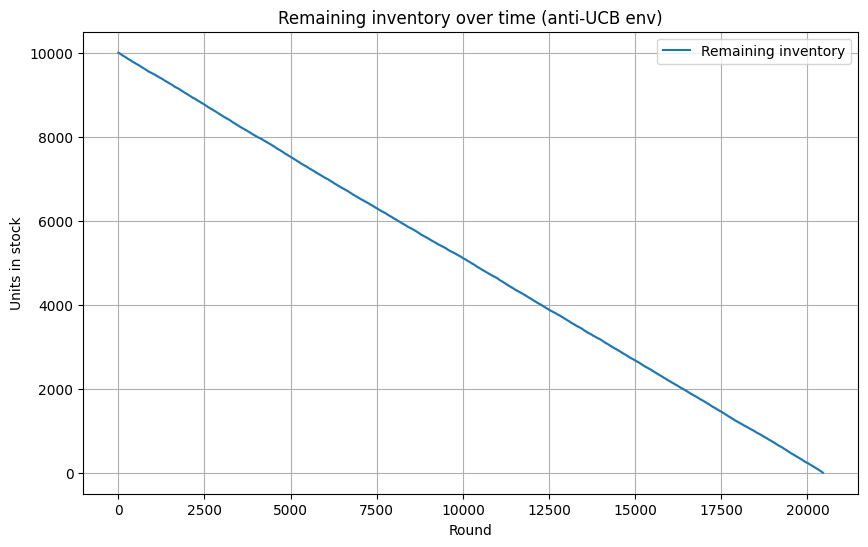

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
T = 50_000
inventory = 10_000  # set smaller (e.g., 10_000) to see a clear slope

ucb = UCB1Agent(T)
agent = EXP3Agent(T)
env = AntiUCB1Environment(agent=ucb, T=T, inventory=inventory)

# --- Simulate ---
inv_remaining = np.empty(T, dtype=float)
rounds_played = 0

for t in range(T):
    # Drive the adversary with a "fake" UCB round (no time advance, no inventory change)
    p_u = ucb.pull_arm()
    r_u = env.fake_round(p_u)
    ucb.update(r_u)

    # Optional early stop if out of stock
    if hasattr(env, "is_stocked_out") and env.is_stocked_out():
        break

    # Real round with EXP3
    p = agent.pull_arm()
    r = env.round(p)
    agent.update(r)

    # Track remaining inventory
    if hasattr(env, "get_inventory_remaining"):
        inv_remaining[t] = env.get_inventory_remaining()
    elif hasattr(env, "inventory"):
        inv_remaining[t] = env.inventory
    else:
        inv_remaining[t] = np.nan

    rounds_played += 1

# --- Regret & reference bound (truncate to played rounds) ---
regret = agent.compute_regret(env)[:rounds_played]
t_values = np.arange(1, rounds_played + 1)
K_bound = agent.K
bound = np.sqrt(K_bound * t_values * np.log(np.maximum(2, t_values)))  # ~ √(K t log t)

# --- Plots ---
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, label='Regret')  # no markers for speed
plt.plot(t_values, bound, linestyle='--', label=r'$\sqrt{K\,t\,\log t}$  (K = agent.K)')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of EXP3 in adversarial setting (anti-UCB)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_values, inv_remaining[:rounds_played], label='Remaining inventory')
plt.xlabel('Round')
plt.ylabel('Units in stock')
plt.title('Remaining inventory over time (anti-UCB env)')
plt.legend()
plt.grid(True)
plt.show()


# Coordinators

In [69]:
import numpy as np

class EXP3Coordinator:
    def __init__(self, T):
        self.T = T
        self.agents = [UCB1Agent(T), EXP3Agent(T)]
        self.N_pulls = np.zeros(len(self.agents))
        self.weights = np.ones(len(self.agents))
        self.learning_rate = np.sqrt(np.log(len(self.agents)) / (len(self.agents) * T))
        self.rewards = np.zeros(T)
        self.t = 0

        # NEW: tracking (does not affect behavior)
        self.inventory_history = np.full(T, np.nan, dtype=float)   # remaining inventory after each round
        self.sales_history = np.full(T, np.nan, dtype=float)       # units sold each round
        self.cumulative_sales = np.full(T, np.nan, dtype=float)    # total units sold up to each round

    def choose_agent(self):
        probabilities = self.weights / np.sum(self.weights)
        chosen_agent_index = np.random.choice(len(self.agents), p=probabilities)
        return self.agents[chosen_agent_index], chosen_agent_index

    def update_weights(self, chosen_agent_index, reward):
        loss = 1 - reward
        estimated_loss = loss / (self.weights[chosen_agent_index] / np.sum(self.weights))
        self.weights[chosen_agent_index] *= np.exp(-self.learning_rate * estimated_loss)

    def run(self, env):
        for t in range(self.T):
            agent, agent_index = self.choose_agent()
            self.N_pulls[agent_index] += 1
            p = agent.pull_arm()
            r = env.round(p)
            self.rewards[t] = r
            agent.update(r)
            self.update_weights(agent_index, r)

            # --- NEW: record remaining inventory & sales ---
            # Remaining inventory after this round
            if hasattr(env, "get_inventory_remaining"):
                inv = env.get_inventory_remaining()
            else:
                inv = getattr(env, "inventory", np.nan)
            self.inventory_history[t] = inv

            # Units sold this round (prefer diff of inventories; fallback to NaN)
            if t == 0:
                if hasattr(env, "initial_inventory") and env.initial_inventory is not None and not np.isnan(inv):
                    self.sales_history[t] = env.initial_inventory - inv
                else:
                    self.sales_history[t] = np.nan
            else:
                prev_inv = self.inventory_history[t - 1]
                if not np.isnan(prev_inv) and not np.isnan(inv):
                    self.sales_history[t] = prev_inv - inv
                else:
                    self.sales_history[t] = np.nan

            # Cumulative sales (prefer initial_inventory if available)
            if hasattr(env, "initial_inventory") and env.initial_inventory is not None and not np.isnan(inv):
                self.cumulative_sales[t] = env.initial_inventory - inv
            else:
                if t == 0:
                    self.cumulative_sales[t] = self.sales_history[t]
                else:
                    if not np.isnan(self.cumulative_sales[t - 1]) and not np.isnan(self.sales_history[t]):
                        self.cumulative_sales[t] = self.cumulative_sales[t - 1] + self.sales_history[t]
                    else:
                        self.cumulative_sales[t] = np.nan

        # Calculate regret for each agent (unchanged)
        regrets = [agent.compute_regret(env) for agent in self.agents]
        return regrets


In [70]:
import numpy as np

class UCB1Coordinator:
    def __init__(self, T):
        self.T = T
        self.agents = [UCB1Agent(T), EXP3Agent(T)]
        self.N_pulls = np.zeros(len(self.agents))
        self.total_rewards = np.zeros(len(self.agents))
        self.rewards = np.zeros(T)
        self.t = 0

        # NEW: track remaining inventory after each round (no behavior change)
        self.inventory_history = np.full(T, np.nan, dtype=float)

    def choose_agent(self):
        if self.t < len(self.agents):
            chosen_agent_index = self.t
        else:
            ucbs = self.total_rewards / self.N_pulls + np.sqrt(2 * np.log(self.t) / self.N_pulls)
            chosen_agent_index = np.argmax(ucbs)
        return self.agents[chosen_agent_index], chosen_agent_index

    def update_rewards(self, chosen_agent_index, reward):
        self.total_rewards[chosen_agent_index] += reward

    def run(self, env):
        for t in range(self.T):
            self.t = t
            agent, agent_index = self.choose_agent()
            self.N_pulls[agent_index] += 1
            p = agent.pull_arm()
            r = env.round(p)
            self.rewards[t] = r
            agent.update(r)
            self.update_rewards(agent_index, r)

            # NEW: record remaining inventory (after the round)
            if hasattr(env, "get_inventory_remaining"):
                inv = env.get_inventory_remaining()
            else:
                inv = getattr(env, "inventory", np.nan)
            self.inventory_history[t] = inv

        # Calculate regret for each agent (unchanged)
        regrets = [agent.compute_regret(env) for agent in self.agents]
        return regrets


# Tests

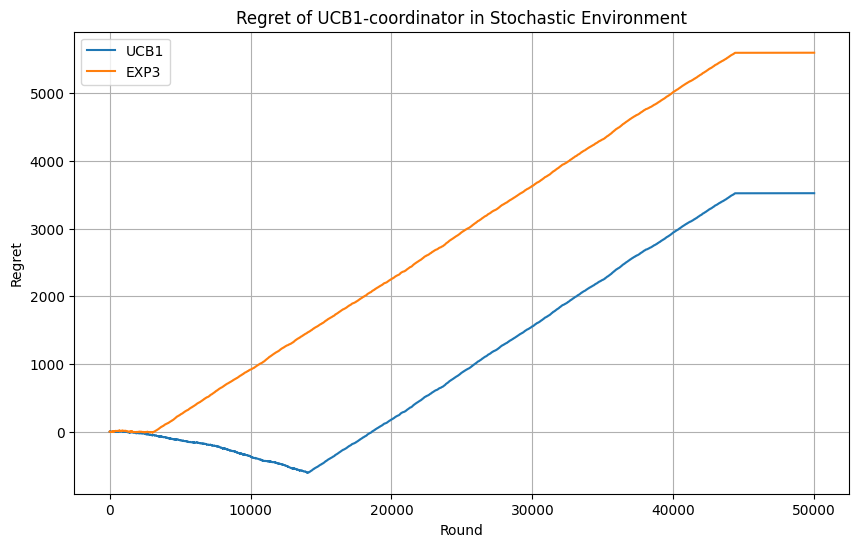

Final remaining inventory: 0
Total units sold: 10000


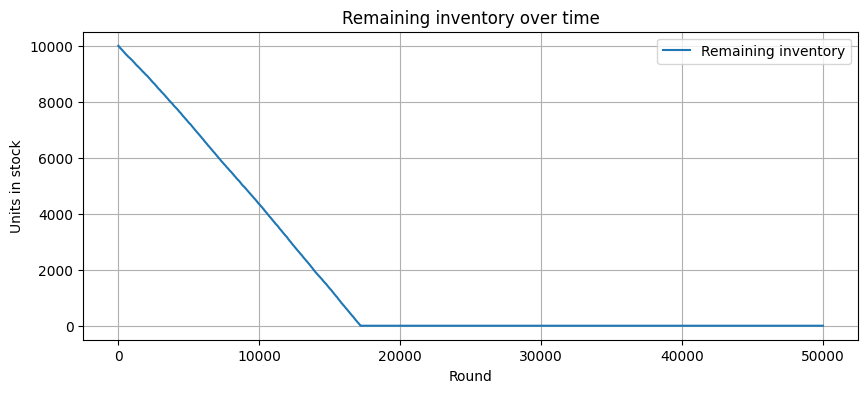

[39665. 10335.]


In [71]:
# Example usage
T = 50000
coordinator = UCB1Coordinator(T)
env = StochasticEnvironment(cost = 5, var = 20, T = T, K = 1, inventory=inventory)
regrets = coordinator.run(env)

# Plotting the regrets for each agent
plt.figure(figsize=(10, 6))
plt.plot(range(T), regrets[0], label=f'UCB1')
plt.plot(range(T), regrets[1], label=f'EXP3')

plt.xlabel('Round')
plt.ylabel('Regret')
plt.title('Regret of UCB1-coordinator in Stochastic Environment')
plt.legend()
plt.grid(True)
plt.show()

# ---- Inventory & sales summary/plots ----
inv_hist = coordinator.inventory_history  # filled once per round

# Print final numbers
if hasattr(env, "initial_inventory") and env.initial_inventory is not None:
    final_inv = int(inv_hist[-1])
    total_sold = int(env.initial_inventory - final_inv)
    print(f"Final remaining inventory: {final_inv}")
    print(f"Total units sold: {total_sold}")
else:
    # If no inventory cap, just report the last observed inventory value
    print(f"Final remaining inventory: {inv_hist[-1]}")

# Plot remaining inventory over time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(T), inv_hist, label="Remaining inventory")
plt.xlabel("Round")
plt.ylabel("Units in stock")
plt.title("Remaining inventory over time")
plt.legend()
plt.grid(True)
plt.show()

print(coordinator.N_pulls)

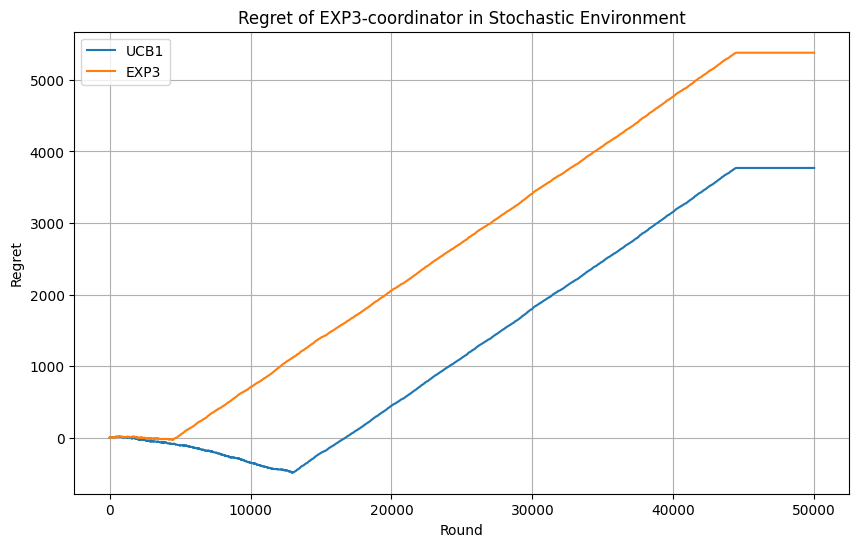

Final remaining inventory: 0
Total units sold: 10000


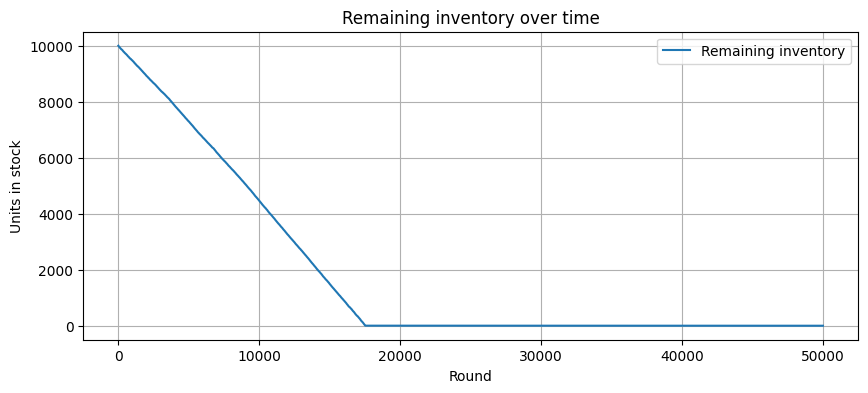

[37011. 12989.]


In [72]:
# Example usage
T = 50000
coordinator = EXP3Coordinator(T)
env = StochasticEnvironment(cost = 5, var = 20, T = T, K = 1, inventory=inventory)
regrets = coordinator.run(env)

# Plotting the regrets for each agent
plt.figure(figsize=(10, 6))
plt.plot(range(T), regrets[0], label=f'UCB1')
plt.plot(range(T), regrets[1], label=f'EXP3')

plt.xlabel('Round')
plt.ylabel('Regret')
plt.title('Regret of EXP3-coordinator in Stochastic Environment')
plt.legend()
plt.grid(True)
plt.show()

# ---- Inventory & sales summary/plots ----
inv_hist = coordinator.inventory_history  # filled once per round

# Print final numbers
if hasattr(env, "initial_inventory") and env.initial_inventory is not None:
    final_inv = int(inv_hist[-1])
    total_sold = int(env.initial_inventory - final_inv)
    print(f"Final remaining inventory: {final_inv}")
    print(f"Total units sold: {total_sold}")
else:
    # If no inventory cap, just report the last observed inventory value
    print(f"Final remaining inventory: {inv_hist[-1]}")

# Plot remaining inventory over time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(T), inv_hist, label="Remaining inventory")
plt.xlabel("Round")
plt.ylabel("Units in stock")
plt.title("Remaining inventory over time")
plt.legend()
plt.grid(True)
plt.show()

print(coordinator.N_pulls)

/tmp/ipython-input-1188585049.py:22: RuntimeWarning: divide by zero encountered in divide
  2 * np.log(self.T) / self.agent.N_pulls


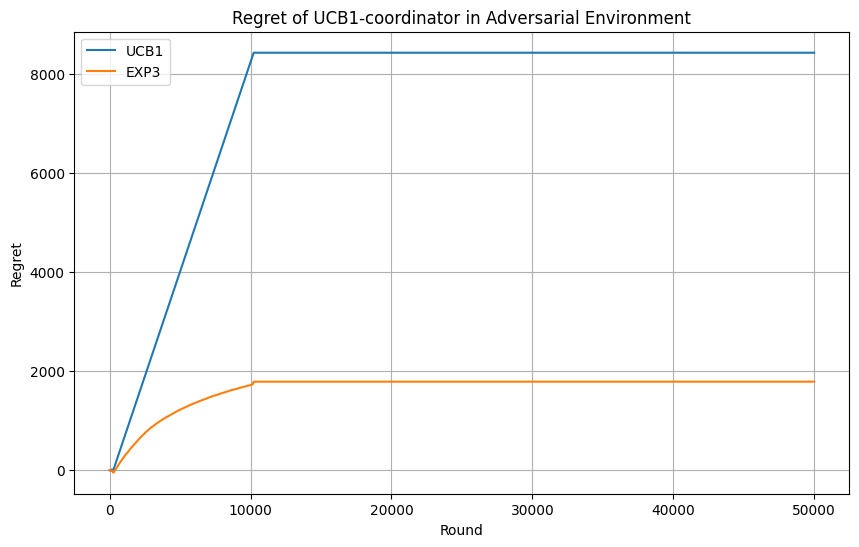

Final remaining inventory: 0
Total units sold: 10000


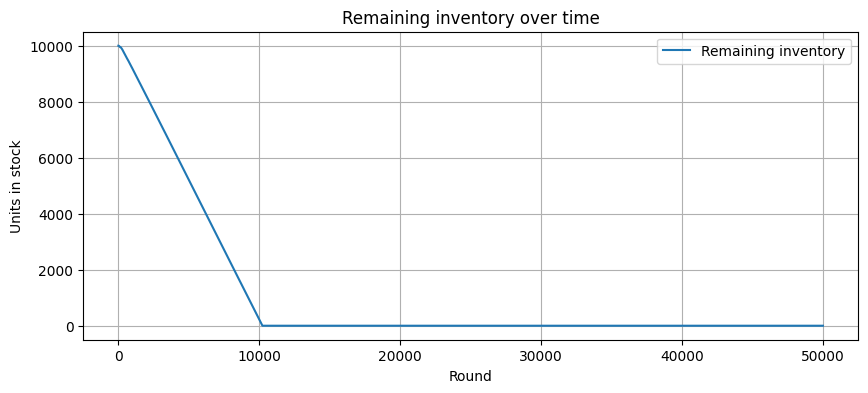

array([  888., 49112.])

In [73]:
# Example usage
T = 50000
coordinator = UCB1Coordinator(T)
env = AntiUCB1Environment(agent = coordinator.agents[0], T = T, inventory=inventory)
regrets = coordinator.run(env)

# Plotting the regrets for each agent
plt.figure(figsize=(10, 6))
plt.plot(range(T), regrets[0], label=f'UCB1')
plt.plot(range(T), regrets[1], label=f'EXP3')

plt.xlabel('Round')
plt.ylabel('Regret')
plt.title('Regret of UCB1-coordinator in Adversarial Environment')
plt.legend()
plt.grid(True)
plt.show()

# ---- Inventory & sales summary/plots ----
inv_hist = coordinator.inventory_history  # filled once per round

# Print final numbers
if hasattr(env, "initial_inventory") and env.initial_inventory is not None:
    final_inv = int(inv_hist[-1])
    total_sold = int(env.initial_inventory - final_inv)
    print(f"Final remaining inventory: {final_inv}")
    print(f"Total units sold: {total_sold}")
else:
    # If no inventory cap, just report the last observed inventory value
    print(f"Final remaining inventory: {inv_hist[-1]}")

# Plot remaining inventory over time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(T), inv_hist, label="Remaining inventory")
plt.xlabel("Round")
plt.ylabel("Units in stock")
plt.title("Remaining inventory over time")
plt.legend()
plt.grid(True)
plt.show()

coordinator.N_pulls

/tmp/ipython-input-1188585049.py:22: RuntimeWarning: divide by zero encountered in divide
  2 * np.log(self.T) / self.agent.N_pulls


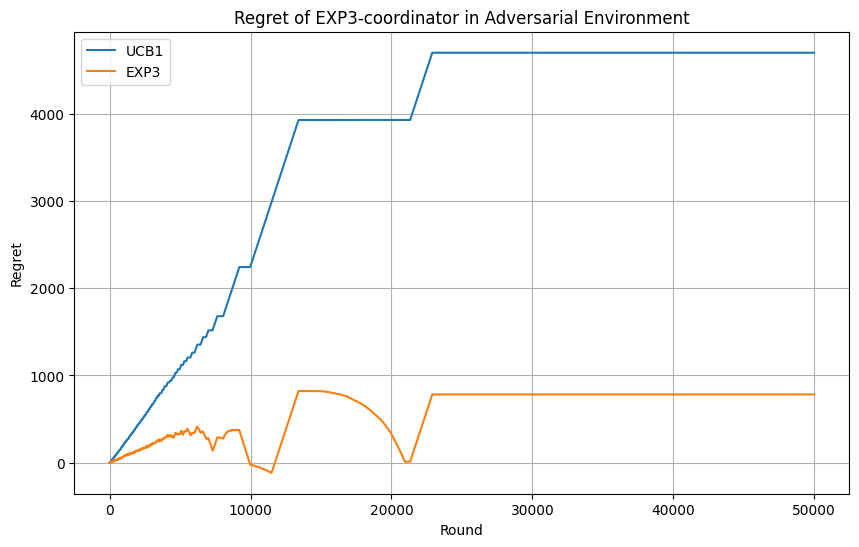

Final remaining inventory: 0
Total units sold: 10000


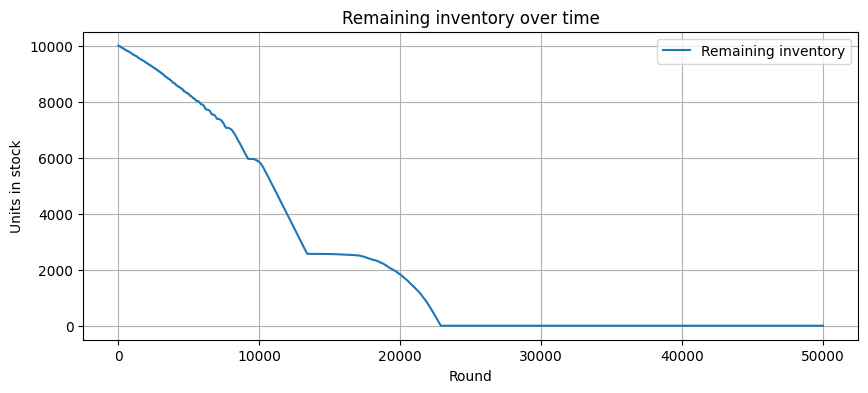

array([ 2918., 47082.])

In [74]:
# Example usage
T = 50000
coordinator = EXP3Coordinator(T)
env = AntiUCB1Environment(agent = coordinator.agents[0], T = T, inventory=inventory)
regrets = coordinator.run(env)

# Plotting the regrets for each agent
plt.figure(figsize=(10, 6))
plt.plot(range(T), regrets[0], label=f'UCB1')
plt.plot(range(T), regrets[1], label=f'EXP3')

plt.xlabel('Round')
plt.ylabel('Regret')
plt.title('Regret of EXP3-coordinator in Adversarial Environment')
plt.legend()
plt.grid(True)
plt.show()

# ---- Inventory & sales summary/plots ----
inv_hist = coordinator.inventory_history  # filled once per round

# Print final numbers
if hasattr(env, "initial_inventory") and env.initial_inventory is not None:
    final_inv = int(inv_hist[-1])
    total_sold = int(env.initial_inventory - final_inv)
    print(f"Final remaining inventory: {final_inv}")
    print(f"Total units sold: {total_sold}")
else:
    # If no inventory cap, just report the last observed inventory value
    print(f"Final remaining inventory: {inv_hist[-1]}")

# Plot remaining inventory over time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(T), inv_hist, label="Remaining inventory")
plt.xlabel("Round")
plt.ylabel("Units in stock")
plt.title("Remaining inventory over time")
plt.legend()
plt.grid(True)
plt.show()

coordinator.N_pulls